<a href="https://colab.research.google.com/github/montjoile/Meta-learning/blob/master/bias_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Code for Testing Bias 

\\

This notebook contains experiments to check the presence of bias in the three datasets. I refer as Bias as the intrinsic characteristics of the images in each dataset. The goal is to train a model that can recognize which dataset an image is from. If the model scores more than 33% of accuracy, we can say the datasets are biased, as the model would be able to recognize the inherent characteristics of the datasets. If the performance of the model is no greater than 33% it would mean that the images in the datasets are similar, so we can proceed to design a further meta-learning model. 

My hypothesis is that there exist unique characteristics in each dataset that will make the images differentiable between datasets.

\\

**This notebook contains:**

* Experiment to detect dataset bias
* Cross validation to detect bias


\\

**Notes:**

I used a random state of 42 on the train/test spllit for reproducible results, this will change to completely random on the final testing in the hpc.
I used a very small batch of samples from the original dataset on this notebook. (326 samples from the 3 datasets). The reason was the limitation of Colab environment. The results of the same experiments with the full samples are expected to be similar that the ones obtained here.


\\

**Observations:**

* It is worth to note that the class proportion within the train and test set differ, one sign of dataset shift, but the model perform with very high accuracy on the test set, which is highly imbalanced, suggesting that there is no symtoms of data shift.

\\

**Results:**

* In the two experiments, the model was unable to detect which dataset the sample images are from, which means that **there is no presence of dataset bias**. 


\\


The experiment performed here is *Name that dataset!* which can be found  [here](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.208.2314&rep=rep1&type=pdf)

### Mount Google drive

In [3]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Import Libraries

In [4]:
import pandas as pd
import numpy as np
import os
from keras.utils import np_utils
from sklearn.utils import shuffle, class_weight
from PIL import Image
from keras.preprocessing import image
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential, load_model
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import cv2
import shutil
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras import models
from sklearn.model_selection import KFold
from keras import optimizers
from sklearn.metrics import classification_report, precision_recall_fscore_support
import sklearn.metrics as metrics
from imblearn.keras import BalancedBatchGenerator
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
import pandas as pd
from pathlib import Path
import time
import matplotlib.image as mpimg
import math
import seaborn as sn
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import itertools
import seaborn as sns

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


###Load data

In [0]:
#read dataset with path of images
df_melanoma = pd.read_csv('/content/drive/My Drive/meta-learning/df_melanoma_colab.csv')

#create dataset name codes
dataset_codename = {
    'addi-melanoma':1,
    'derm7pt-melanoma':2,
    'skin-melanoma':3
}

In [0]:
Counter(df_melanoma['dataset-name'])

Counter({'addi-melanoma': 77, 'derm7pt-melanoma': 160, 'skin-melanoma': 89})

###Functions definition

In [0]:
#create generators
def create_generators(x_train, x_test, label_col):
  img_height = 256
  img_width = 256
  img_dimension = 3

  #train datagenerator
  datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
  train_generator = datagen.flow_from_dataframe(
          dataframe=x_train,
          x_col='path',
          y_col=label_col,
          subset='training',
          target_size=(256, 256),
          batch_size=32,
          shuffle=True,
          color_mode='rgb',
          class_mode='categorical')
  
  #valid datagenerator
  valid_generator=datagen.flow_from_dataframe(
          dataframe=x_train,
          x_col='path',
          y_col=label_col,
          subset='validation',
          target_size=(256,256),
          batch_size=32,
          shuffle=True,
          color_mode='rgb',
          class_mode='categorical')

  #test datagenerator
  testgen = ImageDataGenerator()
  test_generator = testgen.flow_from_dataframe(
          dataframe=x_test,
          x_col='path',
          y_col=label_col,
          target_size=(256, 256),
          batch_size=32,
          shuffle=False,
          color_mode='rgb',
          class_mode='categorical')
  
  return train_generator, valid_generator, test_generator

In [0]:
# create model
def create_model():
  
  model = Sequential()

  model.add(Conv2D(16, 9, padding='same', input_shape=(256,256,3), use_bias=False))

  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D())


  model.add(Flatten())
  model.add(Dense(512, activation='sigmoid', use_bias=False))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Dense(activation='softmax', units=3))

  model.compile(loss='categorical_crossentropy', 
                optimizer = keras.optimizers.SGD(
                    lr=0.01, 
                    momentum=0.9, 
                    nesterov=True),
                metrics=["accuracy"])
  
  return model

In [0]:
# fit model 
def train_model(model, train_generator, valid_generator, weight_checkpoint):
  
  nb_epochs = 3 
  STEP_SIZE_TRAIN=math.ceil(train_generator.n//nb_epochs)
  STEP_SIZE_VALID=math.ceil(valid_generator.n//nb_epochs)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  
  history = model.fit_generator(generator=train_generator,
                                           steps_per_epoch=STEP_SIZE_TRAIN,
                                           validation_data=valid_generator,
                                           validation_steps=STEP_SIZE_VALID,
                                           callbacks=[es, weight_checkpoint],
                                           epochs=nb_epochs)
  
  best_weights_model = load_model(weight_checkpoint.filepath)
  
  return history.history['acc'], history.history['loss'], history.history['val_acc'], history.history['val_loss'], best_weights_model


In [0]:
#get predictions
def predict_model(model, test_generator):
  STEP_SIZE_TEST=math.ceil(test_generator.n/test_generator.batch_size)
  true_labels = test_generator.classes
  test_generator.reset()

  predictions = model.predict_generator(test_generator, steps=STEP_SIZE_TEST) 
  y_true = true_labels
  y_pred = np.array([np.argmax(x) for x in predictions])
  return y_true, y_pred

In [0]:
#evaluate model
def evaluate_model(model, test_generator):
  STEP_SIZE_TEST=math.ceil(test_generator.n/test_generator.batch_size)
  loss, acc = model.evaluate_generator(generator=test_generator, steps=STEP_SIZE_TEST)

  return loss, acc

In [0]:
def plot_confusion_matrix(confusion_matrix, class_names):
  mpl.style.use('seaborn')
  conf_arr = np.array([[88,14,4],[12,85,11],[5,15,91]])
  sum = conf_arr.sum()
  conf_arr = conf_arr * 100.0 / ( 1.0 * sum )

  df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)

  fig = plt.figure()
  plt.clf()
  ax = fig.add_subplot(111)
  ax.set_aspect(1)

  cmap = sns.cubehelix_palette(rot=-.4)
  res = sn.heatmap(df_cm, annot=True, vmin=0.0, vmax=100.0, fmt='d', cmap=cmap)
  res.invert_yaxis()
  plt.yticks([0.5,1.5,2.5], class_names, va='center')
  plt.title('Confusion Matrix')

  #plt.savefig('confusion_matrix.png', dpi=100, bbox_inches='tight' )
  #plt.close()

In [0]:
#plot classification report
def plot_classification_report(y_true, y_pred, class_names, figsize=(10, 10), ax=None):

    plt.figure(figsize=figsize)

    xticks = ['precision', 'recall', 'f1-score', 'support']
    yticks = class_names

    rep = np.array(precision_recall_fscore_support(y_true, y_pred)).T
    avg = np.mean(rep, axis=0)
    avg[-1] = np.sum(rep[:, -1])
    rep = np.insert(rep, rep.shape[0], avg, axis=0)

    cmap = sns.color_palette("ch:2.8,-.2,dark=.27")
    sns.heatmap(rep,
                annot=True, 
                cbar=False, 
                xticklabels=xticks, 
                yticklabels=yticks,
                fmt='.2f',
                cmap=cmap,
                ax=ax)

In [0]:
#plot AUC ROC
def auc_roc(y_true, y_pred):
  fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=0)

  #plot ROC
  plt.plot(fpr,tpr)
  plt.show() 

  #plot AUC
  auc = np.trapz(tpr,fpr)
  print('AUC:', auc)

In [0]:
#plot curves of loss and accuracy during training
def plot_acc_loss(acc, val_acc, loss, val_loss):
  f = plt.figure(figsize=(15,5))
  ax = f.add_subplot(121)
  ax2 = f.add_subplot(122)
  epochs = range(1, len(acc) + 1)

  ax.plot(epochs, acc, 'g', label='Training acc')
  ax.plot(epochs, val_acc, 'b', label='Validation acc')
  #ax.title('Training and validation accuracy')
  ax.set_title('Training and validation accuracy')
  ax.legend()

  ax2.plot(epochs, loss, 'g', label='Training loss')
  ax2.plot(epochs, val_loss, 'b', label='Validation loss')
  ax2.set_title('Training and validation loss')
  ax2.legend()

###Experiment 1

In [0]:
def experimento_1(dataset):
  
  #split dataset into test and train set
  X_train, X_test, y_train, y_test = train_test_split(dataset['path'], dataset['dataset-name'], test_size=0.2, random_state=42)
  X_train = dataset.loc[dataset['path'].isin(X_train)]
  X_test = dataset.loc[dataset['path'].isin(X_test)]
  
  #set weight checkpoint file
  weight_checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/meta-learning/bias_testing1.hdf5', 
                               monitor = 'val_acc',
                               mode='max',
                               verbose=1, 
                               save_best_only=True)
  
  
  #create and evaluate model
  model = create_model()
  train_generator, valid_generator, test_generator = create_generators(X_train, X_test, 'dataset-name')

  
  acc, loss, val_acc, val_loss, best_model = train_model(model, train_generator, valid_generator, weight_checkpoint)
  actual, predicted = predict_model(best_model, test_generator)
  loss_eval, acc_eval = evaluate_model(best_model, test_generator)
  
  
  return acc, loss, val_acc, val_loss, acc_eval, loss_eval, actual, predicted, best_model

In [0]:
acc, loss, val_acc, val_loss, acc_eval, loss_eval, actual, predicted, model = experimento_1(df_melanoma)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 53 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 15 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 166 validated image filenames belonging to 3 classes.
Found 41 validated image filenames belonging to 3 classes.
Found 51 validated image filenames belonging to 3 classes.
Epoch 1/3
55/55 [==============================] - 201s 4s/step - loss: 0.2901 - acc: 0.9063 - val_loss: 0.6931 - val_acc: 0.8022

Epoch 00001: val_acc improved from -inf to 0.80216, saving model to /content/drive/My Drive/meta-learning/bias_testing1.hdf5
Epoch 2/3
55/55 [==============================] - 192s 3s/step - loss: 0.1734 - acc: 0.9392 - val_loss: 2.6570 - val_acc: 0.2941

Epoch 00002: val_acc did not improve from 0.80216
Epoch 3/3
55/55 [==============================] - 191s 3s/step - loss: 0.0750 - acc: 0.9804 - val_loss: 1.6917 - val_acc: 0.5396

Epoch 00003: val_acc did not improve from 0.80216


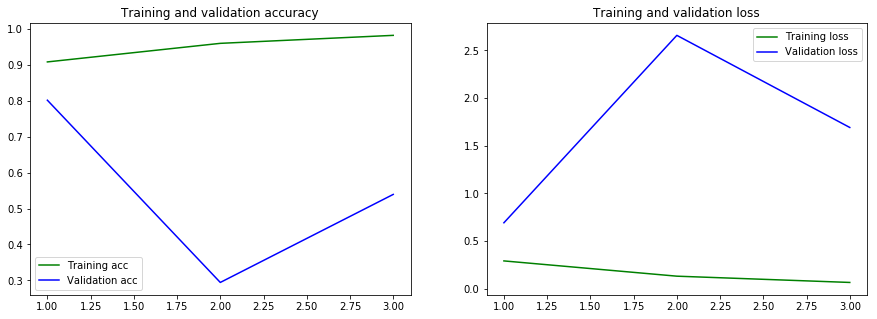

In [0]:
#plot training and validation accuracy and loss
plot_acc_loss(acc, val_acc, loss, val_loss)

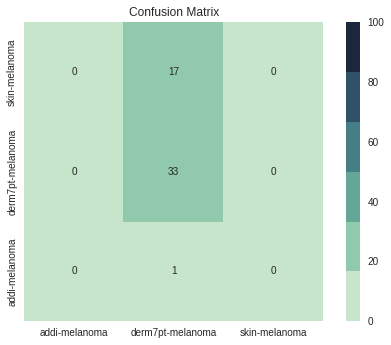

In [0]:
#plot confusion matrix
plot_confusion_matrix(confusion_matrix(actual, predicted), dataset_codename)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


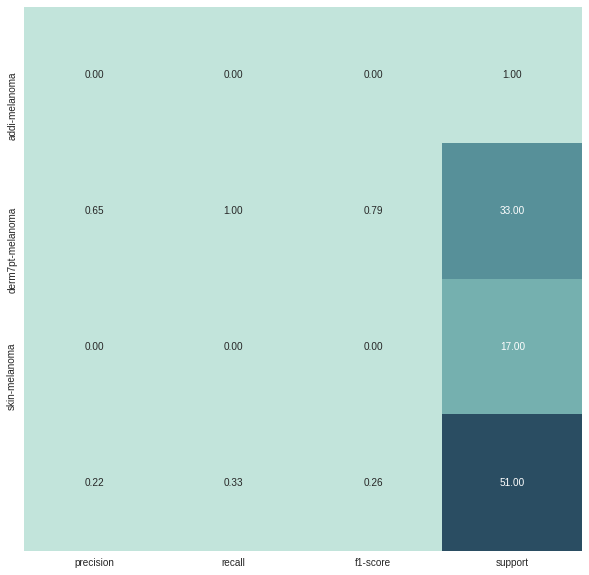

In [0]:
#plot classification report
plot_classification_report(actual, predicted, dataset_codename)

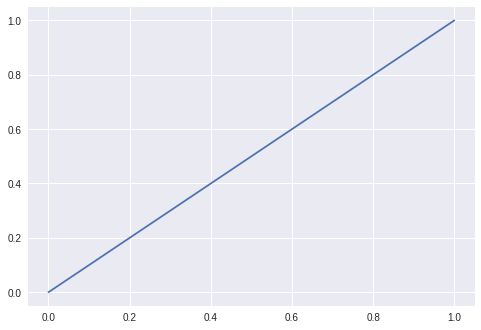

AUC: 0.5


In [0]:
#plot AUC ROC
auc_roc(actual, predicted)

###Experiment 2

In [0]:
def experimento_2(dataset):
    
  total_actual = []
  total_predicted = []
  total_acc = []
  total_loss = []
  total_val_acc = []
  total_val_loss = []
  total_acc_eval = []
  total_loss_eval = []
  total_test_accuracy = []

  kf = KFold(n_splits=3, shuffle=True)
  kf.get_n_splits(dataset['path'])


  for i, (train_index, test_index) in enumerate(kf.split(dataset['path'])):  
    X_train, X_test = dataset.iloc[train_index], dataset.iloc[test_index]
    y_train, y_test = dataset.iloc[train_index]['dataset-name'], dataset.iloc[test_index]['dataset-name']      

    #set weight checkpoint file
    if os.path.exists('/content/drive/My Drive/meta-learning/bias_testing2.hdf5'): os.remove('/content/drive/My Drive/meta-learning/bias_testing2.hdf5')
    weight_checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/meta-learning/bias_testing2.hdf5', 
                                 monitor = 'val_acc',
                                 verbose=1, 
                                 save_best_only=True)

    print('***** Running fold '+ str(i)+' *****')
    print('train size: '+str(X_train.shape[0]))
    print('test size: ' +str(X_test.shape[0]))

    #create and evaluate model
    model = None
    model = create_model()
    train_generator, valid_generator, test_generator = create_generators(X_train, X_test, 'dataset-name')


    acc, loss, val_acc, val_loss, best_model = train_model(model, train_generator, valid_generator, weight_checkpoint)
    actual, predicted = predict_model(best_model, test_generator)
    loss_eval, acc_eval = evaluate_model(best_model, test_generator)


    #append validation accuracy and loss for average calculation later on
    total_acc.append(acc)
    total_loss.append(loss)
    total_val_acc.append(val_acc)
    total_val_loss.append(val_loss)

    print('actual size:'+str(len(actual)))
    print('predicted size:'+str(len(predicted)))

    #append accuracy from the predictions on the test data
    total_test_accuracy.append(accuracy_score(actual, predicted))

    #append all of the actual and predicted classes for your final evaluation
    total_actual.append(actual)
    total_predicted.append(predicted)

    total_loss_eval.append(loss_eval)
    total_acc_eval.append(acc_eval)


  #modify to plot
  y_true = []
  y_pred = []
  for i in range(0,len(total_actual)):
    for j in range(0, len(total_actual[i])):
        y_true.append(total_actual[i][j])
  for i in range(0,len(total_predicted)):
    for j in range(0, len(total_predicted[i])):
        y_pred.append(total_predicted[i][j])

  return acc, loss, val_acc, val_loss, acc_eval, loss_eval, y_true, y_pred, best_model

In [16]:
acc, loss, val_acc, val_loss, acc_eval, loss_eval, actual, predicted, model = experimento_2(df_melanoma)

W0803 23:31:22.060047 140111407294336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0803 23:31:22.104955 140111407294336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0803 23:31:22.113948 140111407294336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0803 23:31:22.175599 140111407294336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0803 23:31:22.177342 1401114072

***** Running fold 0 *****
train size: 217
test size: 109


W0803 23:31:22.482074 140111407294336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0803 23:31:22.571453 140111407294336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0803 23:31:22.693299 140111407294336 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0803 23:31:22.737228 140111407294336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: Th

Found 136 validated image filenames belonging to 3 classes.
Found 33 validated image filenames belonging to 3 classes.
Found 89 validated image filenames belonging to 3 classes.


W0803 23:31:23.105175 140111407294336 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/3
45/45 [==============================] - 151s 3s/step - loss: 0.2915 - acc: 0.9130 - val_loss: 1.0095 - val_acc: 0.7563

Epoch 00001: val_acc improved from -inf to 0.75635, saving model to /content/drive/My Drive/meta-learning/bias_testing2.hdf5
Epoch 2/3
45/45 [==============================] - 146s 3s/step - loss: 0.1175 - acc: 0.9661 - val_loss: 0.7589 - val_acc: 0.7289

Epoch 00002: val_acc did not improve from 0.75635
Epoch 3/3
45/45 [==============================] - 145s 3s/step - loss: 0.0972 - acc: 0.9688 - val_loss: 1.2179 - val_acc: 0.5736

Epoch 00003: val_acc did not improve from 0.75635
actual size:89
predicted size:89
***** Running fold 1 *****
train size: 217
test size: 109


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 42 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 26 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 140 validated image filenames belonging to 3 classes.
Found 35 validated image filenames belonging to 3 classes.
Found 83 validated image filenames belonging to 3 classes.
Epoch 1/3
46/46 [==============================] - 154s 3s/step - loss: 0.3671 - acc: 0.9046 - val_loss: 0.7337 - val_acc: 0.8551

Epoch 00001: val_acc improved from -inf to 0.85507, saving model to /content/drive/My Drive/meta-learning/bias_testing2.hdf5
Epoch 2/3
46/46 [==============================] - 151s 3s/step - loss: 0.0644 - acc: 0.9865 - val_loss: 0.6143 - val_acc: 0.8315

Epoch 00002: val_acc did not improve from 0.85507
Epoch 3/3
46/46 [==============================] - 150s 3s/step - loss: 0.0564 - acc: 0.9876 - val_loss: 0.4321 - val_acc: 0.8599

Epoch 00003: val_acc improved from 0.85507 to 0.85990, saving model to /content/drive/My Drive/meta-learning/bias_testing2.hdf5
actual size:83
predicted size:83
***** Running fold 2 *****
train size: 218
test size: 108


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 46 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 22 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 138 validated image filenames belonging to 3 classes.
Found 34 validated image filenames belonging to 3 classes.
Found 86 validated image filenames belonging to 3 classes.
Epoch 1/3
46/46 [==============================] - 153s 3s/step - loss: 0.3304 - acc: 0.9161 - val_loss: 0.8454 - val_acc: 0.8564

Epoch 00001: val_acc improved from -inf to 0.85644, saving model to /content/drive/My Drive/meta-learning/bias_testing2.hdf5
Epoch 2/3
46/46 [==============================] - 150s 3s/step - loss: 0.1087 - acc: 0.9616 - val_loss: 0.7693 - val_acc: 0.8488

Epoch 00002: val_acc did not improve from 0.85644
Epoch 3/3
46/46 [==============================] - 149s 3s/step - loss: 0.0489 - acc: 0.9903 - val_loss: 0.6425 - val_acc: 0.7921

Epoch 00003: val_acc did not improve from 0.85644
actual size:86
predicted size:86


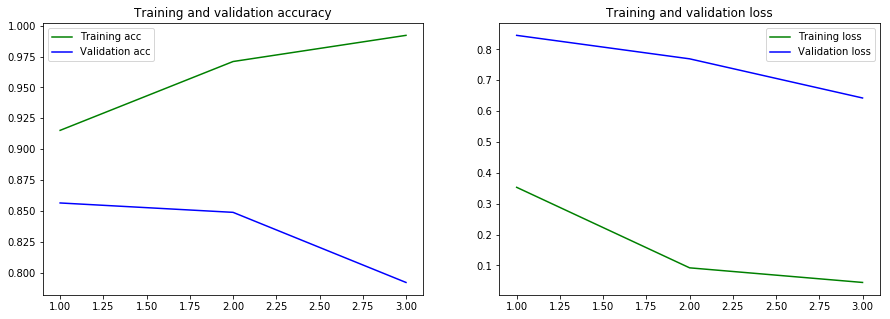

In [19]:
#plot training and validation accuracy and loss
plot_acc_loss(acc, val_acc, loss, val_loss)

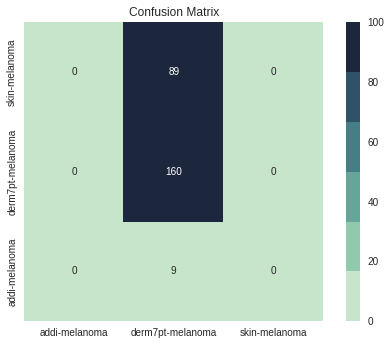

In [21]:
#plot confusion matrix
plot_confusion_matrix(confusion_matrix(actual, predicted), dataset_codename)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


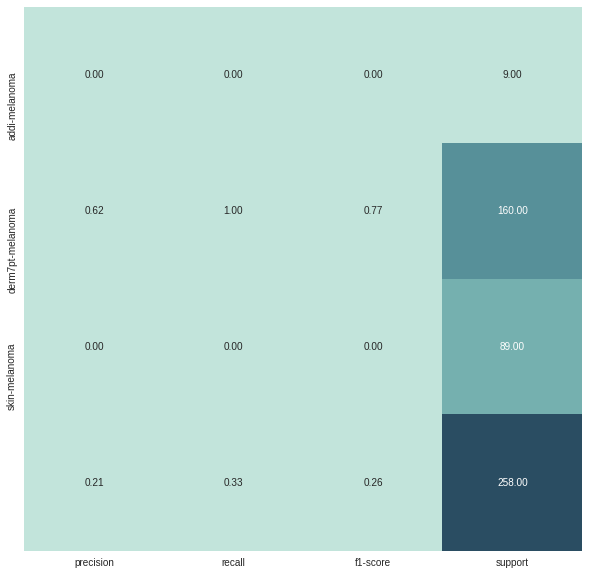

In [22]:
#plot classification report
plot_classification_report(actual, predicted, dataset_codename)

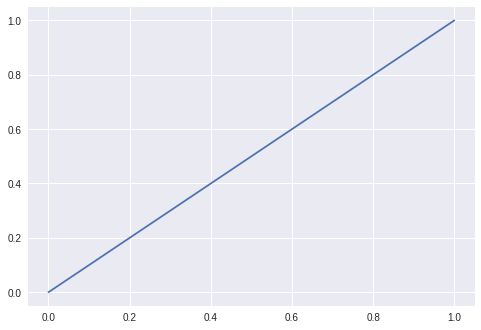

AUC: 0.5


In [23]:
#plot AUC ROC
auc_roc(actual, predicted)